In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import matplotlib.pyplot as plt

import nltk
import string
from wordcloud import WordCloud

from nltk.tokenize import RegexpTokenizer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LinearRegression
from sklearn import metrics

from collections import defaultdict

from mlxtend.plotting import plot_confusion_matrix


C:\Users\salik\AppData\Local\Programs\Python\Python39\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## Import Data

In [73]:
movie_df = pd.read_csv('Data/tmdb_movies_data.csv')
wiki_df = pd.read_csv('Data/wiki_movie_plots_deduped.csv')

movie_df.columns = movie_df.columns.str.lower()
wiki_df.columns = wiki_df.columns.str.lower()

## PreProcessing

In [9]:
movie_df['original_title'] = movie_df['original_title'].str.lower()
wiki_df['title'] = wiki_df['title'].str.lower()
cols_to_use = movie_df.columns.difference(wiki_df.columns)

wiki_df['plot'] = wiki_df['plot'].str.lower()

In [10]:
df = pd.merge(wiki_df, movie_df[cols_to_use],  how='inner', left_on=['title','release year'], right_on=['original_title','release_year'])
df.drop_duplicates(inplace=True)

In [17]:
df.head(2)

release year      title origin/ethnicity        director  \
0          1960  13 ghosts         American  William Castle   
1          1960  the alamo         American      John Wayne   

                                                cast    genre  \
0                         Charles Herbert, Jo Morrow  unknown   
1  John Wayne, Richard Widmark, Laurence Harvey, ...  unknown   

                                           wiki page  \
0            https://en.wikipedia.org/wiki/13_Ghosts   
1  https://en.wikipedia.org/wiki/The_Alamo_(1960_...   

                                                plot  budget  budget_adj  ...  \
0  when occultist uncle dr. plato zorba wills a h...       0         0.0  ...   
1  the film depicts the battle of the alamo and t...       0         0.0  ...   

  popularity                               production_companies  release_date  \
0   0.110511       Columbia Pictures|William Castle Productions      8/5/1960   
1   0.310398  United Artists|Batjac Productions|The Alamo Co...    10/24/1960   

  release_year revenue revenue_adj runtime  \
0         1960       0         0.0      85   
1         1960       0         0.0     167   

                                             tagline vote_average vote_count  
0                 IT'S FUN TO BE SCARED BY 13 GHOSTS          5.5         12  
1  The Mission That Became a Fortress! The Fortre...          6.2         27  

[2 rows x 27 columns]

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6056 entries, 0 to 6055
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   release year          6056 non-null   int64  
 1   title                 6056 non-null   object 
 2   origin/ethnicity      6056 non-null   object 
 3   director              6056 non-null   object 
 4   cast                  6016 non-null   object 
 5   genre                 6056 non-null   object 
 6   wiki page             6056 non-null   object 
 7   plot                  6056 non-null   object 
 8   budget                6056 non-null   int64  
 9   budget_adj            6056 non-null   float64
 10  genres                6056 non-null   object 
 11  homepage              1506 non-null   object 
 12  id                    6056 non-null   int64  
 13  imdb_id               6056 non-null   object 
 14  keywords              5667 non-null   object 
 15  original_title       

In [19]:
df['genre'].value_counts()[:10]

comedy             1048
drama               866
horror              431
unknown             409
thriller            284
action              274
crime drama         204
science fiction     183
romantic comedy     123
fantasy              86
Name: genre, dtype: int64

In [ ]:
#Make new binning columns
for a,b in df.iterrows():
    if b['genre'] == 'comedy' or b['genre'] == 'Comedy':
        df.at[a, 'genre_new'] = 1
        df.at[a, 'genre_cat'] = 'Comedy'
    elif b['genre'] == 'drama' or b['genre'] == 'Drama':
        df.at[a, 'genre_new'] = 2
        df.at[a, 'genre_cat'] = 'Drama'
    elif b['genre'] == 'horror' or b['genre'] == 'Horror':
        df.at[a, 'genre_new'] = 3
        df.at[a, 'genre_cat'] = 'Horror'
    elif b['genre'] == 'thriller' or b['genre'] == 'Thriller':
        df.at[a, 'genre_new'] = 4
        df.at[a, 'genre_cat'] = 'Thriller'
    elif b['genre'] == 'action' or b['genre'] == 'Action':
        df.at[a, 'genre_new'] = 5
        df.at[a, 'genre_cat'] = 'Action'
    elif b['genre'] == 'adventure' or b['genre'] == 'Adventure':
        df.at[a, 'genre_new'] = 6
        df.at[a, 'genre_cat'] = 'Adventure'
    else:
        df.at[a, 'genre_new'] = 0
        df.at[a, 'genre_cat'] = 'Other'

In [21]:
df['genre_cat'].value_counts()[:10]

Other        3075
Comedy       1048
Drama         866
Horror        431
Thriller      284
Action        274
Adventure      78
Name: genre_cat, dtype: int64

# EDA

## Univariate Analysis

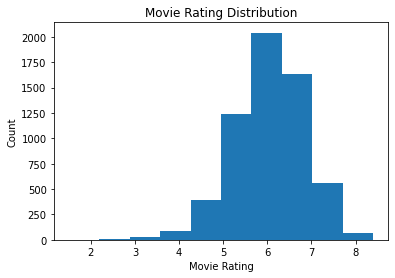

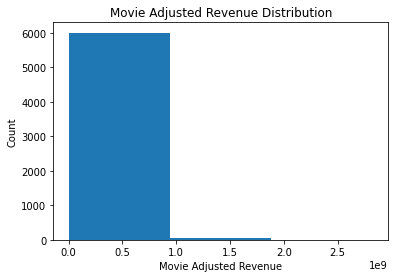

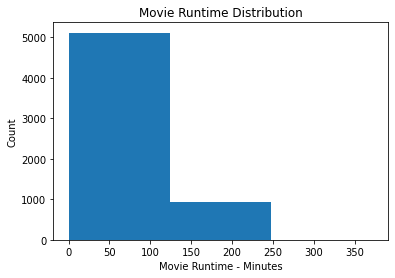

In [22]:
#Movie Rating Distribution
plt.hist(df.vote_average)
plt.xlabel('Movie Rating')
plt.ylabel('Count')
plt.title('Movie Rating Distribution')
plt.show()

#Movie Adjusted Revenue Distribution
plt.hist(df.revenue_adj,bins = 3)
plt.xlabel('Movie Adjusted Revenue')
plt.ylabel('Count')
plt.title('Movie Adjusted Revenue Distribution')
plt.show()

#Movie Adjusted Revenue Distribution
plt.hist(df.runtime,bins = 3)
plt.xlabel('Movie Runtime - Minutes')
plt.ylabel('Count')
plt.title('Movie Runtime Distribution')
plt.show()

## Bivariate Analysis

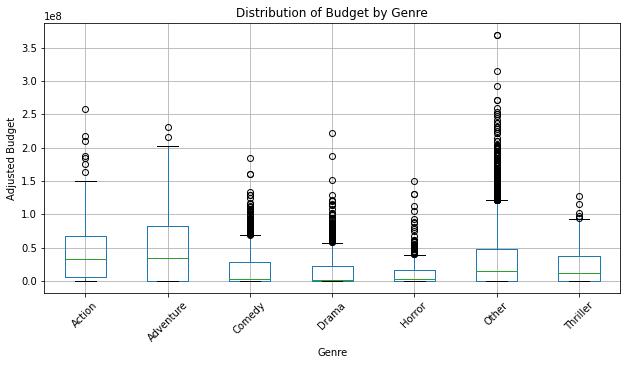

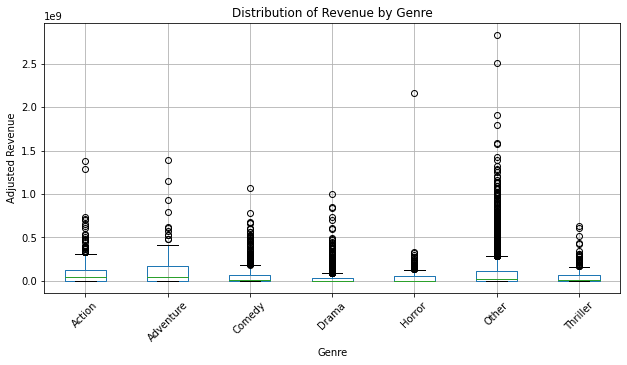

In [23]:
#Create Box Plot
fig1 = df.boxplot(column=['budget_adj'],by ='genre_cat', rot = 45, figsize = (10,5))
#Create Title
plt.title('Distribution of Budget by Genre')
plt.suptitle('')
plt.ylabel('Adjusted Budget')
plt.xlabel('Genre')
#Show Plot
plt.show()

#Create Box Plot
fig1 = df.boxplot(column=['revenue_adj'],by ='genre_cat', rot = 45, figsize = (10,5))
#Create Title
plt.title('Distribution of Revenue by Genre')
plt.suptitle('')
plt.ylabel('Adjusted Revenue')
plt.xlabel('Genre')
#Show Plot
plt.show()

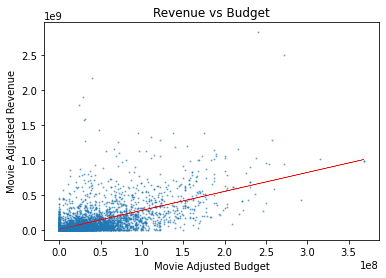

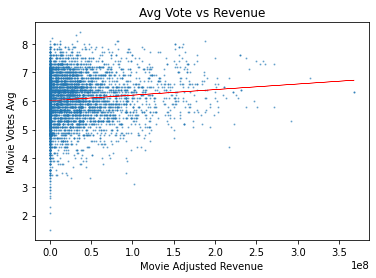

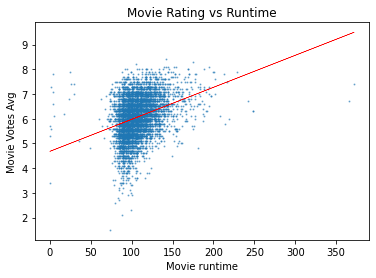

In [20]:
#Movie vs Revenue - Postive Relationship
plt.plot(df.budget_adj, df.revenue_adj, 'o', markersize =1, alpha = 0.5)
m, b = np.polyfit(df.budget_adj, df.revenue_adj, 1)
plt.plot(df.budget_adj, m*df.budget_adj + b, 'red', linewidth = 0.5)
plt.xlabel('Movie Adjusted Budget')
plt.ylabel('Movie Adjusted Revenue')
plt.title('Revenue vs Budget')
plt.show()

#Movie vs Revenue - Weak Relationship
plt.plot(df.budget_adj, df.vote_average, 'o', markersize =1, alpha = 0.5)
m, b = np.polyfit(df.budget_adj, df.vote_average, 1)
plt.plot(df.budget_adj, m*df.budget_adj + b, 'red', linewidth = 0.5)
plt.xlabel('Movie Adjusted Revenue')
plt.ylabel('Movie Votes Avg')
plt.title('Avg Vote vs Revenue')
plt.show()

#Movie vs Revenue - Outliers Contribute
plt.plot(df.runtime, df.vote_average, 'o', markersize =1, alpha = 0.5)
m, b = np.polyfit(df.runtime, df.vote_average, 1)
plt.plot(df.runtime, m*df.runtime + b, 'red', linewidth = 0.5)
plt.xlabel('Movie runtime')
plt.ylabel('Movie Votes Avg')
plt.title('Movie Rating vs Runtime')
plt.show()

## Text Analysis

In [12]:
#String for WordCloud
list123 = ''
#Iterate through training values
for a in wiki_df['plot']:
    list123 += a

In [25]:
nltk.download('wordnet')
nltk.download("stopwords")
nltk.download("punkt")
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\salik\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\salik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\salik\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\salik\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [ ]:
#Create Stop Words Corpus
stop_words = nltk.corpus.stopwords.words("english") + list(string.punctuation) \
+ list(string.ascii_lowercase) + list(string.ascii_uppercase) + list(string.digits) \
+ list(['--']+["''"]+["``"]+[".."]+["..."]+["ii"]+["iii"]+["iv"]+["'s"]+["the"]+["however"] \
+ ["when"]+["as"]+["meanwhile"]+['eventually'])

In [17]:
#Tokenize Words
HR1_token = nltk.word_tokenize(list123)
#Remove Stops words
hr1_filter = [w for w in HR1_token if not w in stop_words]
#Count Words
hr1_counter = Counter(hr1_filter)
#Sort Words by counts
sorted_word_counts = sorted(list(hr1_counter.values()), reverse=True)

In [19]:
#10 Most Common Words in the Movie Plot Corpus
hr1_counter.most_common(10)

[('one', 28863),
 ('father', 23164),
 ('back', 22234),
 ('tells', 19613),
 ('two', 19603),
 ('love', 19343),
 ('also', 17523),
 ('man', 17494),
 ('home', 17321),
 ('family', 17220)]

In [23]:
#Initiate Word Lemmatizer
wordnet_lemmatizer = nltk.stem.WordNetLemmatizer()
#Get Lemmatized Word
lemmatized = [wordnet_lemmatizer.lemmatize(t) for t in hr1_filter]
#Create Counter
bow = Counter(lemmatized)
#Print 10 most common words
print(bow.most_common(10))

[('find', 30546), ('get', 29685), ('one', 29383), ('go', 27238), ('take', 26785), ('tell', 23549), ('father', 23399), ('back', 22439), ('love', 22307), ('life', 21397)]


In [27]:
nouns = {}
cccc = hr1_counter.most_common()
for a in cccc:
    pos_sentences = nltk.word_tokenize(a[0])
    tag = nltk.pos_tag(pos_sentences)
    tag = tag[0]
    if tag[1] == 'NN':
        nouns[a[0]] = a[1]

In [29]:
nouns1 = Counter(nouns)
#Print 30 most common Nouns
print(nouns1.most_common(30))

[('father', 23164), ('love', 19343), ('man', 17494), ('home', 17321), ('family', 17220), ('house', 16861), ('time', 16303), ('life', 15922), ('mother', 15017), ('day', 14297), ('wife', 13670), ('film', 13543), ('son', 13182), ('help', 12828), ('money', 11811), ('night', 11429), ('daughter', 11363), ('friend', 11358), ('death', 10903), ('kill', 10240), ('car', 9936), ('’', 9535), ('way', 9331), ('woman', 8972), ('story', 8944), ('girl', 8762), ('brother', 8663), ('school', 8368), ('return', 8037), ('escape', 7885)]


### Word Cloud without Stop Words of Movie Plots

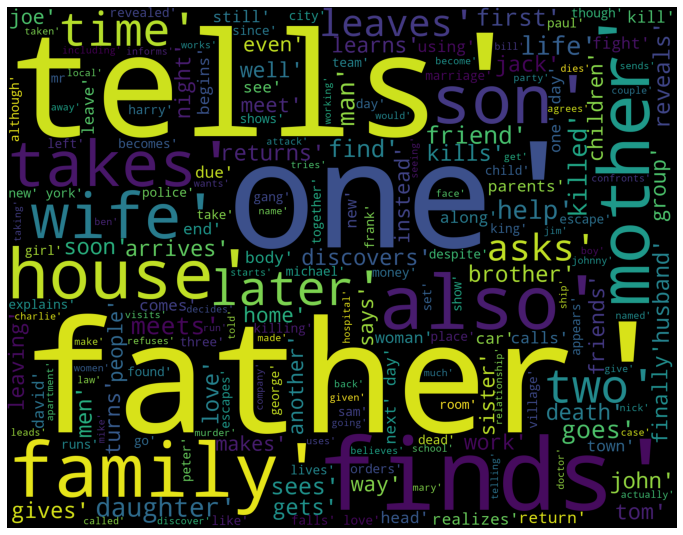

In [31]:
#Set Width & Height
width = 12
height = 12
#Initialize Plot
plt.figure(figsize=(width, height))
#Generate Wordplot
wordcloud = WordCloud(width=1800,height=1400).generate(str(hr1_filter))
#Show Plot
plt.imshow(wordcloud)
plt.axis("off")
#Generate Plot
plt.show()

### Word Cloud without Stop Words of Lemmatized words in Movie Plots

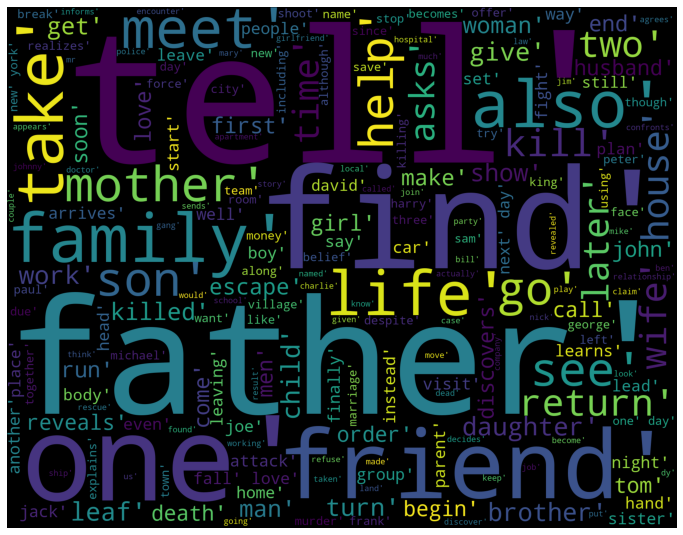

In [33]:
#Set Width & Height
width = 12
height = 12
#Initialize Plot
plt.figure(figsize=(width, height))
#Generate Wordplot
wordcloud = WordCloud(width=1800,height=1400).generate(str(lemmatized))
#Show Plot
plt.imshow(wordcloud)
plt.axis("off")
#Generate Plot
plt.show()

# Predictive Models

In [35]:
#New DF with orginal Wiki Data
df2aa = wiki_df
#Make new binning columns
for a,b in df2aa.iterrows():
    if b['genre'] == 'comedy' or b['genre'] == 'Comedy':
        df2aa.at[a, 'genre_new'] = 1
        df2aa.at[a, 'genre_cat'] = 'Comedy'
    elif b['genre'] == 'drama' or b['genre'] == 'Drama':
        df2aa.at[a, 'genre_new'] = 2
        df2aa.at[a, 'genre_cat'] = 'Drama'
    elif b['genre'] == 'horror' or b['genre'] == 'Horror':
        df2aa.at[a, 'genre_new'] = 3
        df2aa.at[a, 'genre_cat'] = 'Horror'
    elif b['genre'] == 'thriller' or b['genre'] == 'Thriller':
        df2aa.at[a, 'genre_new'] = 4
        df2aa.at[a, 'genre_cat'] = 'Thriller'
    elif b['genre'] == 'action' or b['genre'] == 'Action':
        df2aa.at[a, 'genre_new'] = 5
        df2aa.at[a, 'genre_cat'] = 'Action'
    elif b['genre'] == 'adventure' or b['genre'] == 'Adventure':
        df2aa.at[a, 'genre_new'] = 6
        df2aa.at[a, 'genre_cat'] = 'Adventure'
    else:
        df2aa.at[a, 'genre_new'] = 0
        df2aa.at[a, 'genre_cat'] = 'Other'
#Make new binning columns
for a,b in df2aa.iterrows():
    if b['genre'] == 'comedy' or b['genre'] == 'Comedy':
        df2aa.at[a, 'Comedy'] = 1
    else:
        df2aa.at[a, 'Comedy'] = 0
#Assign X-Data
X3 = df2aa['plot']
#Assign Target Data
y3 = df2aa['genre_new']
y2 = df2aa['Comedy']

## Predict if movie plot is comedy of not

## Naives Bayes Model

In [37]:
# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X3, y2 , test_size = 0.33, random_state = 53)
# Create and fit & Transform the Vectorizer
count_vectorizer2 = CountVectorizer(stop_words = 'english')
count_train3 = count_vectorizer2.fit_transform(X_train.values) 
count_test3 = count_vectorizer2.transform(X_test.values)

In [39]:
# Create and fit the model
nb_classifier = MultinomialNB()
nb_classifier.fit(count_train3, y_train)
# Predict on the test features, print the results
pred1 = nb_classifier.predict(count_test3)
# Print the accuracy
metrics.accuracy_score(y_test, pred1)

0.8522539737687831

In [41]:
print("Confusion Matrix:")
print(metrics.confusion_matrix(y_test, pred1))
print("\n\n Classification Report:\n")
print(metrics.classification_report(y_test, pred1))

Confusion Matrix:
[[9111  960]
 [ 741  701]]


 Classification Report:

              precision    recall  f1-score   support

         0.0       0.92      0.90      0.91     10071
         1.0       0.42      0.49      0.45      1442

    accuracy                           0.85     11513
   macro avg       0.67      0.70      0.68     11513
weighted avg       0.86      0.85      0.86     11513



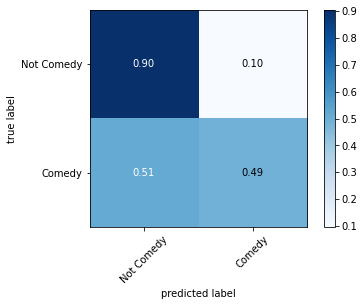

In [43]:
classes = ['Not Comedy', 'Comedy']
cm = metrics.confusion_matrix(y_test, pred1)

figure, ax = plot_confusion_matrix(conf_mat = cm,
                                   class_names = classes,
                                   show_absolute = False,
                                   show_normed = True,
                                   colorbar = True)

plt.show()

## Predict if movie plot is Comedy, Drama, Horror, Thriller, Action, Adventure, or other.

## Regression Model

In [45]:
# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X3, y3 , test_size = 0.33, random_state = 53)
# Create and fit & Transform the Vectorizer
count_vectorizer2 = CountVectorizer(stop_words = 'english')
count_train3 = count_vectorizer2.fit_transform(X_train.values) 
count_test3 = count_vectorizer2.transform(X_test.values)

In [47]:
# Create and fit the model
linreg = LinearRegression().fit(count_train3,y_train)
# Predict on the test features, print the results
pred3 = linreg.predict(count_test3)

# The mean squared error
print('Mean squared error: %.4f'
      % metrics.mean_squared_error(pred3,y_test))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.4f'
      % metrics.r2_score(pred3, y_test))

Mean squared error: 19.6508
Coefficient of determination: -0.0672


## Naives Bayes Model

In [49]:
# Create and fit the model
nb_classifier = MultinomialNB()
nb_classifier.fit(count_train3, y_train)
# Predict on the test features, print the results
pred2 = nb_classifier.predict(count_test3)
metrics.accuracy_score(y_test, pred2)

0.5969773299748111

In [51]:
print("Confusion Matrix:")
print(metrics.confusion_matrix(y_test, pred2))
print("\n\n Classification Report:\n")
print(metrics.classification_report(y_test, pred2))

Confusion Matrix:
[[5051  694  949   95    6   58   11]
 [ 456  712  268    4    0    2    0]
 [ 829  228  908    7    1    3    4]
 [ 166    8   29  166    0    0    0]
 [ 217   28   67   20    1    3    0]
 [ 294   13   12    0    0   23    0]
 [ 142    5   21    0    0    0   12]]


 Classification Report:

              precision    recall  f1-score   support

         0.0       0.71      0.74      0.72      6864
         1.0       0.42      0.49      0.45      1442
         2.0       0.40      0.46      0.43      1980
         3.0       0.57      0.45      0.50       369
         4.0       0.12      0.00      0.01       336
         5.0       0.26      0.07      0.11       342
         6.0       0.44      0.07      0.12       180

    accuracy                           0.60     11513
   macro avg       0.42      0.32      0.33     11513
weighted avg       0.58      0.60      0.58     11513



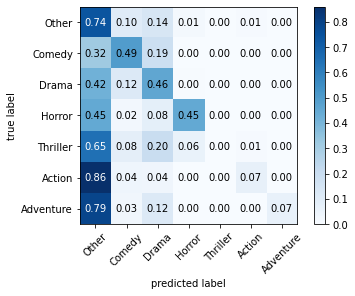

In [53]:
classes = ['Other','Comedy','Drama','Horror','Thriller','Action','Adventure']
cm = metrics.confusion_matrix(y_test, pred2)

figure, ax = plot_confusion_matrix(conf_mat = cm,
                                   class_names = classes,
                                   show_absolute = False,
                                   show_normed = True,
                                   colorbar = True)

plt.show()

## Recommendation System

In [71]:
#Remove NaNs from OverView Column
movie_df = movie_df.dropna(subset = ['overview'])
#Create A title Columns
movie_df['title'] = movie_df['original_title']
wiki_df2 = wiki_df[wiki_df['origin/ethnicity'] == 'American']

In [58]:
#Create TFIDF Vectorizer
tfidf = TfidfVectorizer(stop_words = 'english')

In [62]:
#Fit & Transform on movie overview corpus
tfidf_matrix2 = tfidf.fit_transform(movie_df['overview'])
#Create a Cosine Similarity Matrix on corpus
cosine_sim2 = metrics.pairwise.linear_kernel(tfidf_matrix2, tfidf_matrix2)

In [72]:
#Create TFIDF Vectorizer on Wikepdia Movie Plot corpus
tfidf_matrix = tfidf.fit_transform(wiki_df2['plot'][:10000])
cosine_sim = metrics.pairwise.linear_kernel(tfidf_matrix, tfidf_matrix)

In [67]:
# Generate mapping between titles and index
indices1 = pd.Series(movie_df.index, index=movie_df['title']).drop_duplicates()

def get_recommendations2(title, cosine_sim, indices = indices1):
    # Get index of movie that matches title
    idx = indices[title]
    # Sort the movies based on the similarity scores
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Get the scores for 10 most similar movies
    sim_scores = sim_scores[:11]
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]
    # Return the top 10 most similar movies
    return movie_df['title'].iloc[movie_indices]

# Generate mapping between titles and index
indices2 = pd.Series(wiki_df2.index, index=wiki_df2['title']).drop_duplicates()

def get_recommendations(title, cosine_sim, indices = indices2):
    # Get index of movie that matches title
    idx = indices[title]
    # Sort the movies based on the similarity scores
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Get the scores for 10 most similar movies
    sim_scores = sim_scores[:11]
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]
    # Return the top 10 most similar movies
    return wiki_df2['title'].iloc[movie_indices]

In [68]:
get_recommendations2('jurassic world',cosine_sim2, indices1)

0                              jurassic world
5391            the lost world: jurassic park
6947                                dark ride
10223                           jurassic park
10192                             futureworld
1195     trailer park boys: don't legalize it
5710          tom and jerry's giant adventure
510                             jurassic city
5741                               austenland
4882                           jurassic shark
798                               the nut job
Name: title, dtype: object